In [ ]:
!mkdir Dataset
!wget  https://zenodo.org/records/12769930/files/LandslideData.gpkg?download=1  -O Dataset/LandslideData.gpkg


In [ ]:
import numpy as np
import seaborn as sns
import os
import geopandas as gpd # Read Shapefiles and other vector dataset
import tensorflow as tf # Deep Learning Library
from tensorflow import keras 
from tensorflow.keras.layers import *
from tensorflow.keras import layers, optimizers, losses, metrics, Model

In [ ]:
# prepare data
df = gpd.read_file("Dataset/LandslideData.gpkg")
constcols = ["Est_m", "Nrt_m", "HC_m", "VC_m", "Slp_m", "Prc_m", "NDVI_m","Bdod_m"]
Xdata = df[constcols].to_numpy()
Ydata = df.Landslide.to_numpy()

In [ ]:
print(Xdata.mean(axis=0))
print(Ydata.shape)

In [ ]:
# normalize Data
max = Xdata.max(axis=0)
min = Xdata.min(axis=0)
norm_xdata = (Xdata - min) / (max - min)

In [ ]:
print(norm_xdata.mean(axis=0))
print(Ydata.shape)

In [ ]:
# Defining a Landslide Model
class LandslideModel:
    def __init__(self):
        self.depth = 12

    def getclassificationModel(self, in_num=8, out_num=1):
        features_only = Input((in_num,))

        x = layers.Dense(
            units=64,
            name=f"Sus_0",
            kernel_initializer="random_normal",
            bias_initializer="random_normal",
        )(features_only)
        for i in range(1, self.depth + 1):
            x = layers.Dense(
                units=64,
                name=f"Sus_{str(i)}",
                kernel_initializer="random_normal",
                bias_initializer="random_normal",
            )(x)
            x = layers.BatchNormalization()(x)
            x = layers.Activation("relu")(x)
            # x= layers.Dropout(.3)(x)

        out_areaDen = layers.Dense(units=out_num, activation="sigmoid", name="sus")(x)
        self.model = Model(inputs=features_only, outputs=out_areaDen)

    def getOptimizer(
        self, opt=tf.keras.optimizers.Adam, lr=1e-3, decay_steps=10000, decay_rate=0.9
    ):
        lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
            initial_learning_rate=lr, decay_steps=decay_steps, decay_rate=decay_rate
        )
        self.optimizer = opt(learning_rate=lr_schedule)

    def compileModel(self, weights=None):
        self.model.compile(
            optimizer=self.optimizer,
            loss=tf.keras.losses.BinaryCrossentropy(),
            metrics=[
                tf.keras.metrics.BinaryIoU(target_class_ids=[0, 1], threshold=0.5),
                tf.keras.metrics.AUC(),
                tf.keras.metrics.BinaryAccuracy(),
            ],
        )

In [ ]:
# define model
clfmdl = LandslideModel()
clfmdl.getclassificationModel(in_num=8, out_num=1)
clfmdl.getOptimizer()
clfmdl.compileModel()
print(clfmdl.model.summary())

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    norm_xdata, Ydata, test_size=0.30, random_state=42
)

In [ ]:
def trainmodel(model, xdata, ydata):
    NUMBER_EPOCHS = 100
    filepath = "checkpoint.keras"
    BATCH_SIZE = 32

    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath,
        monitor="val_auc",
        verbose=0,
        save_best_only=True,
        save_weights_only=False,
        mode="max",
        save_freq="epoch"
    )
    print(type(xdata), type(ydata))
    hist = model.fit(
        x=xdata,
        y=ydata,
        epochs=NUMBER_EPOCHS,
        batch_size=BATCH_SIZE,
        validation_split=0.2,  # auto validate using 20% of random samples at each epoch
        verbose=1,
        callbacks=[model_checkpoint_callback],
        class_weight={0: 1, 1: 5},
    )
    return hist

In [ ]:
trainmodel(
    clfmdl.model,
    np.array(X_train, dtype=np.float32),
    np.expand_dims(np.array(y_train, dtype=np.float32), axis=-1),
)

In [26]:
# predict in test set
preds = clfmdl.model.predict(X_test)

155/155 [==============================] - 1s 2ms/step


In [27]:
import sklearn.metrics
import matplotlib.pyplot as plt
import seaborn as sns

fpr, tpr, thresholds = sklearn.metrics.roc_curve(y_test, preds)

In [28]:
print(sklearn.metrics.auc(fpr, tpr))
print(sklearn.metrics.confusion_matrix(y_test, np.rint(preds)))

0.8091876886730541
[[3121  889]
 [ 327  623]]


In [30]:
preds2 = preds
preds2[preds > 0.50] = 1
preds2[preds <= 0.50] = 0
sklearn.metrics.accuracy_score(y_test, preds2)

0.8397177419354839

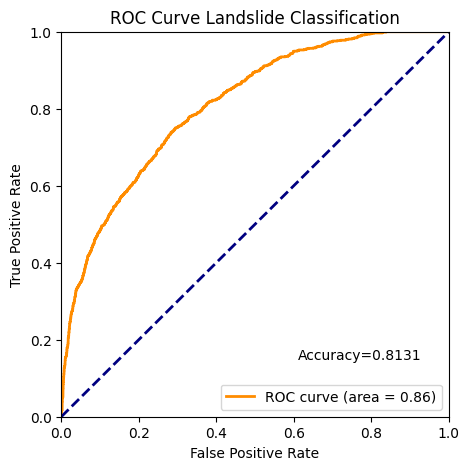

In [36]:
plt.figure(figsize=(5,5))
lw = 2
plt.plot(
    fpr,
    tpr,
    color="darkorange",
    lw=lw,
    label="ROC curve (area = %0.2f)" % 0.8577,
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Landslide Classification")
plt.text(0.61, 0.15, "Accuracy=0.8131")
plt.legend(loc="lower right")
plt.savefig("roc.pdf")
plt.show()